In [2]:
#import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import poisson,skellam
import statsmodels.api as sm
import statsmodels.formula.api as smf
import io
from matplotlib.pyplot import figure

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uploaded = files.upload()

Saving match_data.csv to match_data (1).csv


In [4]:
#load the dataset
df = pd.read_csv(io.BytesIO(uploaded["match_data.csv"]))
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [5]:
total_goals = df["home_score"] + df["away_score"]
df["total goals"] = total_goals
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total goals
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,6
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,3
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,4
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,3


In [6]:
df.loc[[np.argmax(df["total goals"])]]
#create a new dataframe
#truncate the date down to the year for simplicity
df2 = df.copy()
df2['date']=df2['date'].apply(lambda x : int(str.split(x,'-')[0]))
df2.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total goals
0,1872,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,0
1,1873,England,Scotland,4,2,Friendly,London,England,False,6
2,1874,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,3
3,1875,England,Scotland,2,2,Friendly,London,England,False,4
4,1876,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,3


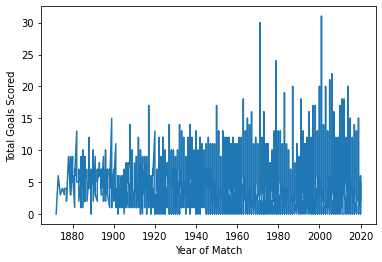

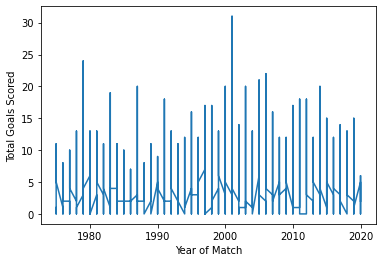

In [7]:
df2['date'].value_counts()
#we have 149 years of data
#restrict the date range
df3=df2.loc[(df2['date']>=1975)]
df3.head()
#produce a plot of data
plt.plot(df2['date'], df2["total goals"])
plt.xlabel("Year of Match")
plt.ylabel("Total Goals Scored")
plt.show()
#truncate the time range to 1975
plt.plot(df3['date'], df3["total goals"])
plt.xlabel("Year of Match")
plt.ylabel("Total Goals Scored")
plt.show()

In [8]:
#let's compute the mean to use in our poisson distribution
df3.iloc[[total_goals.argmax()]]
print(df3["total goals"].mean())

2.7152109548482604


In [ ]:
from scipy.special import factorial
import numpy as np
#k is no. of event we want to find the probability of

def poisson(k,exp_events):
    lam =(exp_events)
    p_k= np.exp(-lam)*np.power(lam,k)/factorial(k)
    print(f'The chance of {k} goals is {100*p_k:.1f}%.')
    return p_k

In [9]:
%pip install sdv

     |████████████████████████████████| 101 kB 8.4 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 52 kB 1.9 MB/s 
     |████████████████████████████████| 46 kB 4.9 MB/s 
     |████████████████████████████████| 1.2 MB 37.2 MB/s 
     |████████████████████████████████| 97 kB 8.2 MB/s 
     |████████████████████████████████| 38.1 MB 300 kB/s 
     |████████████████████████████████| 11.2 MB 59.9 MB/s 
     |████████████████████████████████| 930 kB 38.2 MB/s 
     |████████████████████████████████| 280 kB 70.5 MB/s 
     |████████████████████████████████| 636 kB 70.9 MB/s 
     |████████████████████████████████| 2.5 MB 45.0 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting un

In [17]:
#applying poisson regression to the data
goal_model_data = pd.concat([df3[['home_team','away_team','home_score']].assign(home=1).rename(
            columns={'home_team':'team', 'away_team':'opponent','home_score':'goals'}),
           df3[['away_team','home_team','away_score']].assign(home=0).rename(
            columns={'away_team':'team', 'home_team':'opponent','away_score':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()


In [18]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                64848
Model:                            GLM   Df Residuals:                    64234
Model Family:                 Poisson   Df Model:                          613
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -91556.
Date:                Sun, 01 May 2022   Deviance:                       75428.
Time:                        02:45:00   Pearson chi2:                 6.91e+04
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -0.5581      0.260     -2.145      0.032      -1.068      -0.048
team[T.Afghanistan]                             -0.3830      0.209     -1.832      0.067      -0.793       0.027
team[T.Albania]                                  0.6068      0.196      3.096      0.002       0.223       0.991
team[T.Alderney]                                -1.2930      0.326     -3.962      0.000      -1.933      -0.653
team[T.Algeria]                                  0.8221      0.191      4.314      0.000       0.449       1.195
team[T.American Samoa]                          -1.5441      0.252     -6.120      0.000      -2.039      -1.050
team[T.Andalusia]                                1.1841      0.283      4.180      0.000       0.629       1.739
team[T.Andorra]                                 -0.6886      0.239     -2.886      0.004      -1.156      -0.221
team[T.Angola]                                   0.4939      0.193      2.557      0.011       0.115       0.872
team[T.Anguilla]                                -1.3173      0.251     -5.252      0.000      -1.809      -0.826
team[T.Antigua and Barbuda]                     -0.0508      0.197     -0.257      0.797      -0.438       0.336
team[T.Arameans Suryoye]                         0.1165      0.298      0.392      0.695      -0.467       0.700
team[T.Argentina]                                1.4529      0.189      7.676      0.000       1.082       1.824
team[T.Armenia]                                  0.6477      0.198      3.266      0.001       0.259       1.036
team[T.Artsakh]                                  0.3649      0.245      1.488      0.137      -0.116       0.845
team[T.Aruba]                                   -0.3456      0.219     -1.577      0.115      -0.775       0.084
team[T.Australia]                                0.9636      0.189      5.094      0.000       0.593       1.334
team[T.Austria]                                  1.1571      0.191      6.066      0.000       0.783       1.531
team[T.Azerbaijan]                               0.2477      0.200      1.237      0.216      -0.145       0.640
team[T.Bahamas]                                 -0.6614      0.239     -2.769      0.006      -1.130      -0.193
team[T.Bahrain]                                  0.4917      0.191      2.575      0.010       0.117       0.866
team[T.Bangladesh]                              -0.6243      0.201     -3.101      0.002      -1.019      -0.230
team[T.Barawa]                                  -0.8392      0.307     -2.736      0.006      -1.440      -0.238
team[T.Barbados]                                -0.0403      0.197     -0.205      0.838      -0.426       0.345
team[T.Basque Country]          

In [20]:
def simulate_match(match_model, home_team, away_team, max_goals=10):
    home_goals_avg = match_model.predict(pd.DataFrame(data={'team': home_team, 
                                                            'opponent': away_team,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = match_model.predict(pd.DataFrame(data={'team': away_team, 
                                                            'opponent': home_team,'home':0},
                                                      index=[1])).values[0]
    pred = [[stats.poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(pred[0]), np.array(pred[1])))
#ger_eng = simulate_match(poisson_model, 'germany', 'england', max_goals=10)

In [ ]:
countries = df3.iloc[:, 2].str.split(';',expand=True).stack().unique()
count_countries = [m for m in range(len(countries))]
rev_countries = reversed(countries)
print("There are {var} countries in this football database.".format(var=len(countries)))
win = []
draw = []
loss = []
for i in countries:
    for j in rev_countries:
        simulation = simulate_match(poisson_model, i, j)
        prob_win = np.sum(np.tril(simulation, -1))
        prob_draw = np.sum(np.diag(simulation))
        prob_loss = np.sum(np.triu(simulation, 1))
        win.append(prob_win)
        draw.append(prob_draw)
        loss.append(prob_loss)
print("Win probabilities:", win)
print("Draw probabilities:", draw)
print("Loss probabilities:", loss)

In [13]:
small_df = df3.iloc[0:20, :].copy()
#small_df = df3[df3.iloc > 1].copy()
small_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total goals
9216,1975,Cameroon,Guinea,1,0,Friendly,Yaoundé,Cameroon,False,1
9217,1975,Iraq,Tunisia,0,0,Friendly,Baghdad,Iraq,False,0
9218,1975,Bermuda,Suriname,2,5,Friendly,Hamilton,Bermuda,False,7
9219,1975,Cuba,Canada,4,0,Friendly,Havana,Cuba,False,4
9220,1975,Iraq,Libya,3,1,Friendly,Baghdad,Iraq,False,4


In [14]:
import sdv
#synthetic data
from sdv.tabular import GaussianCopula
model = GaussianCopula()
model.fit(small_df)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:5320: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/copulas/univariate/trunca

In [15]:
sample = model.sample(200)
sample.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total goals
0,1975,Liberia,Haiti,0,0,Friendly,Monrovia,Liberia,False,0
1,1975,Liberia,Suriname,1,2,Friendly,Monrovia,Liberia,False,3
2,1975,Malawi,Mauritius,1,1,Friendly,Blantyre,Malawi,False,2
3,1975,Senegal,Scotland,2,2,Friendly,Dakar,Senegal,False,3
4,1975,Jamaica,Haiti,0,1,Friendly,Kingston,Jamaica,False,1


In [25]:
countries_fake = sample.iloc[:, 2].str.split(';',expand=True).stack().unique()
count_countries = [m for m in range(len(countries_fake))]
rev_countries_fake = reversed(countries_fake)
print("There are {var} countries in this football database.".format(var=len(countries_fake)))
win_fake = []
draw_fake = []
loss_fake = []
for i_fake in countries_fake:
    for j_fake in rev_countries_fake:
        simulation_fake = simulate_match(poisson_model, i_fake, j_fake)
        prob_win_fake = np.sum(np.tril(simulation_fake, -1))
        prob_draw_fake = np.sum(np.diag(simulation_fake))
        prob_loss_fake = np.sum(np.triu(simulation_fake, 1))
        win_fake.append(prob_win_fake)
        draw_fake.append(prob_draw_fake)
        loss_fake.append(prob_loss_fake)
print("Win probabilities:", win_fake)
print("Draw probabilities:", draw_fake)
print("Loss probabilities:", loss_fake)

There are 10 countries in this football database.
Win probabilities: [0.31005430508359266, 0.18949340934967407, 0.3361438155969886, 0.169375582081925, 0.20752653013517358, 0.30615512294144365, 0.13655572714491315, 0.7150149481936028, 0.6256776842023286, 0.4577065903802072]
Draw probabilities: [0.2884432299876126, 0.25560499895924155, 0.2959229528492688, 0.25174382409047624, 0.27560554346534466, 0.27482825642024084, 0.229968380320567, 0.1894567125021954, 0.2166592886761407, 0.27840102794267263]
Loss probabilities: [0.4015023910931105, 0.5549008319074309, 0.367933190190065, 0.5788797099264255, 0.5168676566907165, 0.4190164486162394, 0.6334737392105402, 0.09551883196343411, 0.1576579058485239, 0.2638921991551434]


In [23]:
sample.dropna()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total goals
0,1975,Liberia,Haiti,0,0,Friendly,Monrovia,Liberia,False,0
1,1975,Liberia,Suriname,1,2,Friendly,Monrovia,Liberia,False,3
2,1975,Malawi,Mauritius,1,1,Friendly,Blantyre,Malawi,False,2
3,1975,Senegal,Scotland,2,2,Friendly,Dakar,Senegal,False,3
4,1975,Jamaica,Haiti,0,1,Friendly,Kingston,Jamaica,False,1
...,...,...,...,...,...,...,...,...,...,...
195,1975,Liberia,Scotland,0,2,Friendly,Monrovia,Liberia,False,2
196,1975,Mali,Guinea,1,0,Friendly,Bamako,Mali,False,1
197,1975,Mali,Nigeria,0,3,Friendly,Bamako,Mali,False,3
198,1975,Cameroon,Canada,3,0,Friendly,Yaoundé,Cameroon,False,3


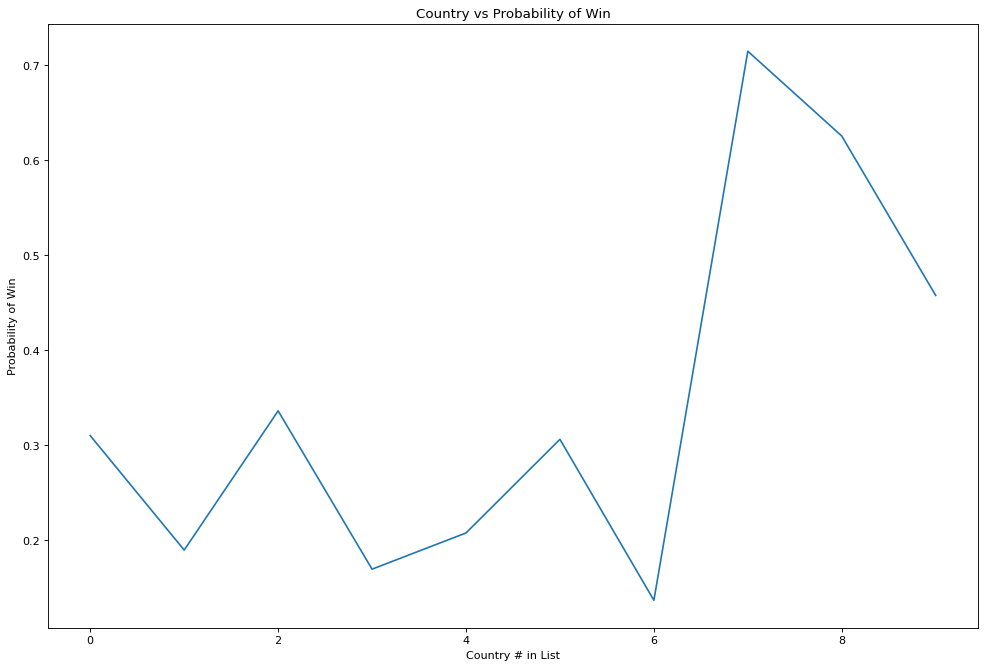

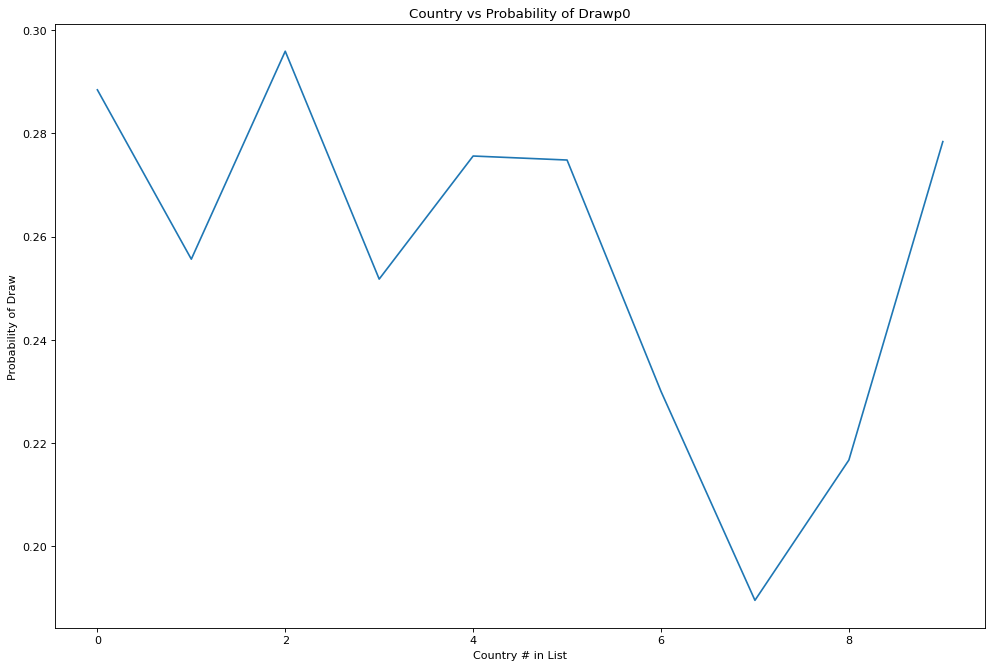

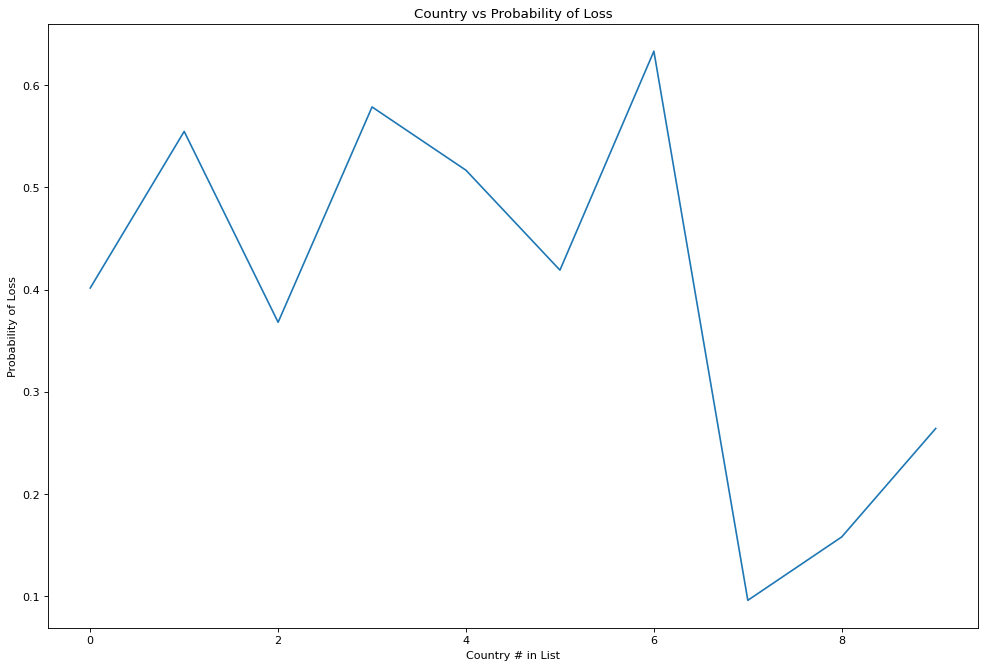

In [26]:
#plotting all the countries
figure(figsize=(15, 10), dpi=80)
plt.plot(count_countries, win_fake)
plt.title("Country vs Probability of Win")
plt.xlabel("Country # in List")
plt.ylabel("Probability of Win")
plt.show()
figure(figsize=(15, 10), dpi=80)
plt.plot(count_countries, draw_fake)
plt.title("Country vs Probability of Drawp0")
plt.xlabel("Country # in List")
plt.ylabel("Probability of Draw")
plt.show()
figure(figsize=(15, 10), dpi=80)
plt.plot(count_countries, loss_fake)
plt.title("Country vs Probability of Loss")
plt.xlabel("Country # in List")
plt.ylabel("Probability of Loss")
plt.show()